# What is ROC
The excellent book "Hands on Machine Learning" explains the ROC curve more thoroughly than I have seen before, but still I don't think I could articulate where the line actually comes from. I can call the functions to draw the curve, and I know that the closer to 1 the area under the curve (AUC) is, the better. I still would like to know where the numbers for the curve come from. So I will explore that here. But before I get into drawing cuves, I should review what they are even used for. 

## Binary Classification
One of the types of problems in machine learning is binary classification. In binary classification you are trying to predict whether a certain condition is true or false. Some examples would be: based on this set of vital statistics, does this person have heart disease; or based on this customer's account activity, are they likely to cancel their account? The example in the book is "Is the digit in this picture a 5?" 

The example uses the MNIST dataset, of 70,000 handwritten digits. In the book, they set aside the last 10,000 images as a test set, and all of the predictions and evaluations are made against a training set of 60,000 images.

I am going to go through the parts of the example needed to provide some context for my ROC exploration. I will be going through the process pretty quickly. For a more detailed explanation, definitely get the book. If you don't understand why I am doing something, it is explained there.

In [1]:
#Load the data
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
# Put the images in X, the correct lables in y
X, y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

In [3]:
# Get the subset that will be our training set. This example won't use a test set.
X_train, y_train = X[:60000], y[:60000]
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [4]:
# The y values are the digits each image represents
y_train[:]

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

In [5]:
# We aren't trying to identify each digit, just whether each digit is a 5.
y_train_5 = (y_train == '5')
y_train_5[:]

array([ True, False, False, ...,  True, False, False])

## Accuracy
The first instinct when evaluating a prediction is to look at accuracy. How often are we guessing correctly.

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Stochastic griadient descent is right over 95% of the time, which sounds awesome. But since only one tenth of the images are of 5s, simply always guessing 'no' would still yield 90% accuracy. 

In [7]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
# DummyClassifier always guesses False
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

Interesting that the dummy classifier is right almost 91% of the time. 5s must be a little underrepresented in our dataset.

In [8]:
sum(y_train_5) / len(y_train_5)

0.09035

Anyway, accuracy does not seem to be the right measure in this case. We need more information.

## ROC Curves
There are many different measures we can use to evaluate our classifier. ROC Curve is one of them. ROC stands for Receiver Operating Characteristic, but that is not important. ROC plots the tradeoff between the true positive rate and the false positive rate.

I don't know have enough experience to have a good intuition of when you would use ROC over other metrics, such as Precision, Recall, Accuraccy, F1 score, etc. I am exploring ROC, because I find it less intuative than the others.  Let's draw a curve, and then go into more details.

The way the classifier works, is that it calculates a score for each image, and then if the score is greater than 0, the prediction is positive, otherwise it negative. Instead of getting the predictions, we can obtain the scores instead. We will need to pass the scores scores to pass into the roc_curve function.

In [9]:
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

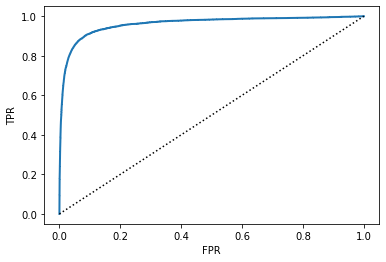

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'k:')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

The ROC curve plots the false positive rate against the true positive rate, both of which range between 0 and 1. As I mentioned above, when we trained the model initially, it was setting the threshold at 0. In our dataset the values range from -146348 to 49441. If we adjust the threshold, we will change the number of cases where we predict positive. If we set the threshold to the bottom of the range, we would predict true 100% of the time, and both the true postive rate and false positive rate would be 100%. 

If we set the threshold at the top of the range, we would predict false 100% of the time, and both TPR and FPR would be 0. Those are the two endpoints of the curve. In between those extremes is where we determine the quality of the model. 

The dotted line represents a completly useless model. At every threshold, every gain in the true positive rate is accompanied by an equal increase in the false positive rate. The blue line is our model. As we start adjusting the threshold, the first cases we predict as positve are the model has the most confidence in, and so the true positive rate rises quickly. 

One thing to note, the threshold we set is not shown on the graph. That was a particular point of confusion for me, especially since the examples I first encountered were using logistic regression, where the thresholds also range from 0 to 1.

So what does the curve tell us? For one thing, it gives a visual indication of how the model compares to random chance. The area under the ROC curve (AUC) or (ROC AUC) is also a useful metric. It gives a score between 0 and 1 that tells us how reliable the predictions are. 

AUC is the probability that any randomly chosen positve example will have a higher score than any randomly chosen negative example. An AUC of 1 means the model is perfect and an AUC of 0.5 means it is useless. An AUC of 0 means that your model is perfect, you just have the labels backwards.

So that is what it is, but I always found the discussion a little vague until I walked through an example at a lower level.

## Confusion Matrices
To evaluate any model, you are comparing what the model predicted to the known answers. For a classifier, the normal procedure is to lay out the predictions and labels in a confusion matrix.

A confusion matrix lists the true classes verses the predictions. In our case, the first row is the cases when the digit was not a 5, and the second row is for the cases when the digit was a 5. The first column is when we guessed "not 5" and the scond column is when we guessed "5".

In [11]:
from sklearn.metrics import confusion_matrix
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, sgd_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In our confusion matrix, we see that in 53,892 cases we guessed "not 5" when the digit was not a 5, these are called True Negatives. We correctly identifed 5s 3,530 times; these are True Positives. We said the digit was a 5 when it wasn't 687 times (False Positive) and said it wasn't a 5 when it was 1,891 times (False Negative). 

There are several statistics that are based on confusion matrices to evalate models, and the tradeoff between false positives and false negatives. The most common are precision TP / (TP + FP), and recall TP / (TP + FN), but the numbers in a confusion matrix also used to calculate each point in an ROC.

The numbers we are going to need going forward are:
    - True Positive Rate (TPR) = TP / (TP + FN) = 3530 / (3530 + 1891)
    - False Positive Rate (FPR) = FP / (FP + TN) =  687 / (687 + 53892)
    - True Negative Rate = TN / (TN + FP) or 1 - FPR
    
The true positive rate is also called "Recall" and the false positve rate is also called "Sensitivity". The true negative rate can be calculated directly from the matrix, but it is usually expressed as 1 - FPR.

The number I have listed are to show how they correspond to the cells in the confusion matrix. If we were to plot the true positive rate against the true negative rate using the numbers above, we would get a single point. To get a curve, we need to get a range of values.

In [12]:
sgd_pred_1000 = (y_scores > 1000)
cm_1000 = confusion_matrix(y_train_5, sgd_pred_1000)
cm_1000

array([[54039,   540],
       [ 2176,  3245]])

In [13]:
sgd_pred_neg_1000 = (y_scores > -1000)
cm_neg_1000 = confusion_matrix(y_train_5, sgd_pred_neg_1000)
cm_neg_1000

array([[53685,   894],
       [ 1625,  3796]])

If we lower the threshold, we will make more positive predictions. Some of the new positive predictions will be correct, and some will be incorrect. We can see the numbers in the confusion matrices. We can also see changes in the true positive rate and false positive rate which both go down because we are making fewper positive predictions.

In [14]:
def cm_to_fpr_tpr(cm):
    tn, fp, fn, tp = cm.reshape(4)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = 1 - tnr
    return fpr, tpr

In [15]:
print(cm_to_fpr_tpr(cm_neg_1000))
print(cm_to_fpr_tpr(cm))
print(cm_to_fpr_tpr(cm_1000))

(0.016379926345297613, 0.7002398081534772)
(0.012587258835816018, 0.6511713705958311)
(0.009893915242126128, 0.5985980446412101)


In [16]:
def plot_roc_by_threshold(thresholds):
    xs = []
    ys = []
    for x in thresholds:
        y_pred_x = (y_scores >= x)
        cm_x = confusion_matrix(y_train_5, y_pred_x)
        fpr, tpr = cm_to_fpr_tpr(cm_x)
        xs.append(fpr)
        ys.append(tpr)

    plt.plot(xs, ys, "o")
    plt.show()

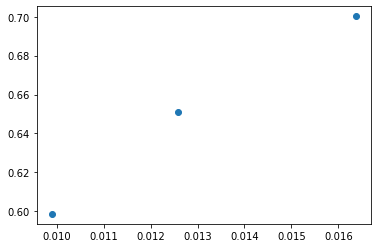

In [17]:
plot_roc_by_threshold([-1000,0,1000])

Plotting these three points makes the function look pretty flat, certainly nothing like what we get when we plot the full ROC curve from the metrics library, below. That is because we are just doing a very small. The full curve goes from 0,0 to 1,1, and we are only graphing from (0.009893915242126128, 0.5985980446412101) to (0.016379926345297613, 0.7002398081534772). 

When we expand the range of thresholds, the curve starts to take shape. Each threshold we are trying yields a true positive rate and a falso positve rate that we can plot against each other.

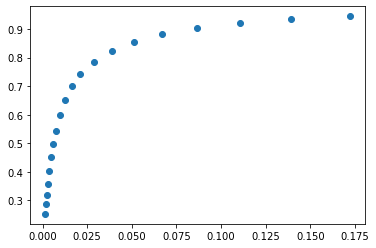

In [18]:
plot_roc_by_threshold(range(-10000,10000,1000))

And when we plot the full range of threshold scores, we can see that this is the same graph that the sklearn.metrics library returned from the roc_curve function.

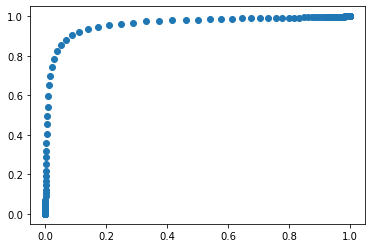

In [19]:
plot_roc_by_threshold(range(-150000,50000,1000))

We are increasing the threshold by 1,000 between each point, which is the only reason we can tell that they are points at all, instead of a continuous line.

## Conclusion

ROC curves, and the area underneath the curve are just one metric you can use to evaluate a binary classifier. A lot of places will tell you what they mean, but hopefully now you understand where they come from.